#**SE7048 -- Group Assignment**

In [ ]:
from google.colab import drive  #for mounting Google drive to Google Colab
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! ls /content/drive/MyDrive/Dataset  #List Directory Contents

Fire  NoFire


In [ ]:
#Importing Libraries
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


In [ ]:
DATADIR = '/content/drive/MyDrive/Dataset'
CATEGORIES = ['Fire', 'NoFire']

In [ ]:
IMG_SIZE = 64  # Resize all images to 64x64

def create_training_data():
    # Load and preprocess images from each category folder (e.g., 'Fire' and 'NoFire')
    training_data = []
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)  # Use numeric labels (0 for 'Fire', 1 for 'NoFire')
        for img in tqdm(os.listdir(path)):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except Exception as e:
                pass
    return training_data


In [ ]:
training_data = create_training_data()


100%|██████████| 1732/1732 [01:28<00:00, 19.50it/s]


In [ ]:
import random
# Print total images, shuffle data, and display the labels of the first 10 samples.
print("Total Training Images:", len(training_data))
random.shuffle(training_data)
for sample in training_data[:10]:
    print(sample[1])


Total Training Images: 2942
1
0
0
0
0
1
1
1
1
1


In [ ]:
# Create lists for images (X) and labels (Y) from the training data
X = []
Y = []
for features, label in training_data:
    X.append(features)
    Y.append(label)

# Convert lists to numpy arrays, reshape to (num_samples, IMG_SIZE, IMG_SIZE, 3), and normalize pixel values
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
X = X / 255.0
print("Shape of X:", X.shape[1:])  # Print the shape (IMG_SIZE, IMG_SIZE, 3)

# Alternatively, convert training data directly to numpy arrays
X = np.array([i[0] for i in training_data], dtype=np.float32) / 255.0
Y = np.array([i[1] for i in training_data], dtype=np.int32)


Shape of X: (64, 64, 3)


#**Task 1**

---



Total Training Images: 2942
Total Test Images: 1001

Random Training Images:


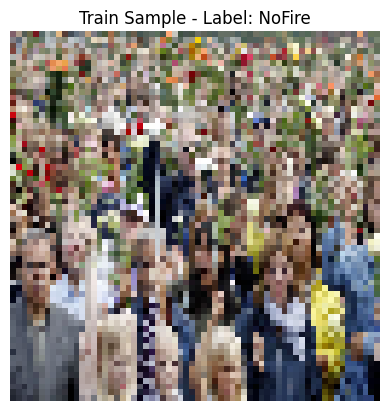

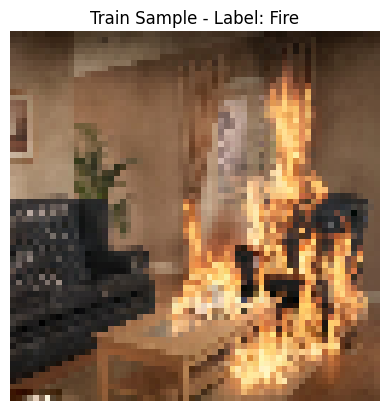

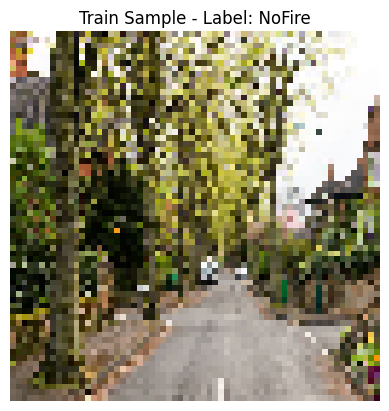

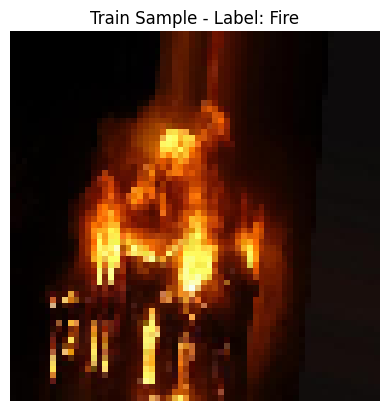

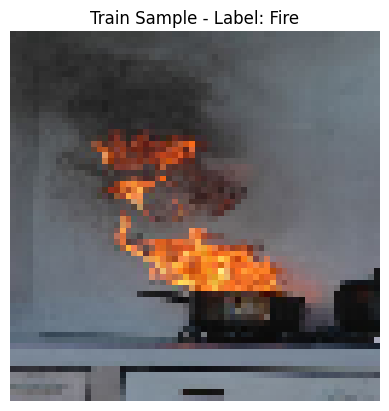


Random Test Images:


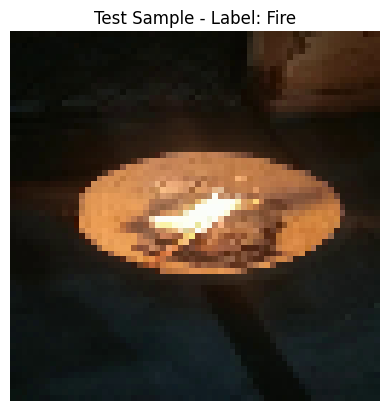

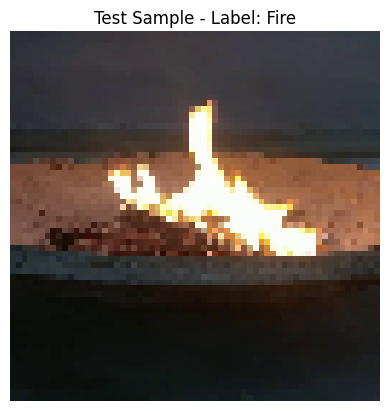

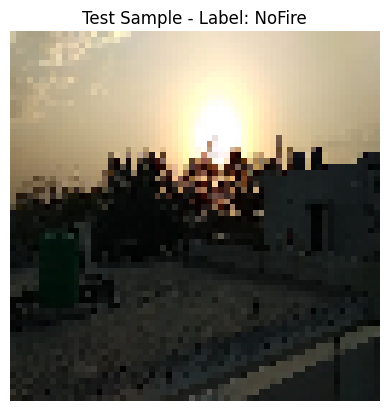

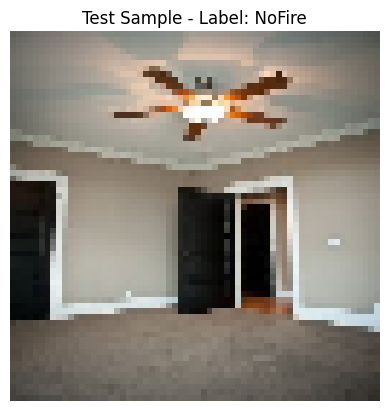

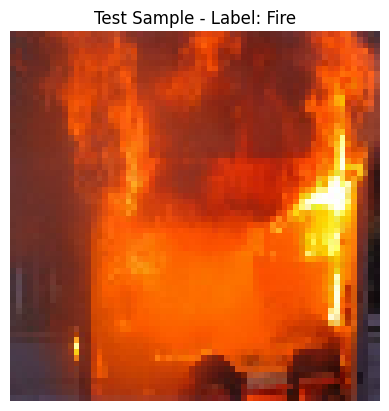

In [ ]:
def create_data(directory):
    """
    Loads images and their labels from the specified directory.
    Each class is in its own sub-folder (named 'Fire' or 'NoFire').
    Images are resized to IMG_SIZE x IMG_SIZE.
    Returns a list of [image, label] pairs.
    """
    data = []
    for category in CATEGORIES:
        path = os.path.join(directory, category)
        # Get the class number (0 for Fire, 1 for NoFire)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                # Read the image
                img_array = cv2.imread(os.path.join(path, img))
                # Resize the image
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                # Append image and its label
                data.append([new_array, class_num])
            except Exception as e:
                pass  # Skip images that cause errors
    return data

# =============================================================================
# Load Data from Training and Test Folders
# =============================================================================

# Folder for training images (combined dataset from Kaggle and other sources)
TRAIN_DIR = '/content/drive/MyDrive/Dataset'
# Folder for test images
TEST_DIR = '/content/drive/MyDrive/Test'

# Load training and test data separately
train_data = create_data(TRAIN_DIR)
test_data = create_data(TEST_DIR)

print("Total Training Images:", len(train_data))
print("Total Test Images:", len(test_data))

# =============================================================================
# Display 5 Random Images from Training and Test Datasets
# =============================================================================

def display_random_images(data, num_images=5, dataset_name="Dataset"):
    """
    Randomly selects and displays 'num_images' images from the provided data list.
    Each element in 'data' is a [image, label] pair.
    """
    # Select random indices from the data list
    indices = random.sample(range(len(data)), num_images)
    for idx in indices:
        image, label = data[idx]
        plt.figure()
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        # Get class name from the label (assumes labels are 0 or 1)
        plt.title(f"{dataset_name} Sample - Label: {CATEGORIES[label]}")
        plt.axis('off')
        plt.show()

# Display 5 random images from the Training dataset
print("\nRandom Training Images:")
display_random_images(train_data, num_images=5, dataset_name="Train")

# Display 5 random images from the Test dataset
print("\nRandom Test Images:")
display_random_images(test_data, num_images=5, dataset_name="Test")


#**Task 2**

---



In [ ]:
# Set up image augmentation to increase dataset diversity and reduce overfitting
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,         # Random rotations up to 15 degrees
    horizontal_flip=True,      # Randomly flip images horizontally
    width_shift_range=0.1,     # Shift images horizontally by up to 10% of the width
    height_shift_range=0.1,    # Shift images vertically by up to 10% of the height
    zoom_range=0.3             # Random zoom by up to 30%
)
datagen.fit(X)  # Fit the augmentation parameters on the dataset X




> Depthwise Separable convolution is a technique that decomposes a standard convolution operation into two separate operations: a **depthwise convolution** and a **pointwise convolution**. This approach reduces the number of parameters and computational cost compared to standard convolution, while maintaining similar performance.









In [ ]:
# Set up a CNN model for fire image classification
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, BatchNormalization, GlobalAveragePooling2D,
                                     Dense, Dropout, SeparableConv2D)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the CNN architecture
model = Sequential([
    SeparableConv2D(16, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    SeparableConv2D(32, (3,3), activation='relu'),
    BatchNormalization(),
    SeparableConv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    GlobalAveragePooling2D(),  # Reduces each feature map to a single value
    Dense(64, activation='relu'),
    Dropout(0.6),              # Prevent overfitting
    Dense(2, activation='softmax')  # Output layer for 2 classes
])

# Compile the model with Adam optimizer and sparse categorical loss
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Path for saving model checkpoints
checkpoint_path = '/content/drive/MyDrive/TrainedModels/Fire-64x64-color-epoch{epoch:02d}-val_acc{val_accuracy:.2f}.h5'

# Stop training if val_accuracy doesn't improve for 30 epochs
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=30,
    verbose=1,
    mode='max',
    restore_best_weights=True
)

# Save best model during training
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=False
)

callbacks_list = [early_stopping, model_checkpoint]

# Print model summary and parameter count
model.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_separable_conv.py:104: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ separable_conv2d (SeparableConv2D)   │ (None, 62, 62, 16)          │              91 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 62, 62, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_1 (SeparableConv2D) │ (None, 60, 60, 32)          │             688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 60, 60, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_2 (SeparableConv2D) │ (None, 58, 58, 64)          │           2,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 58, 58, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,917 (30.93 KB)

 Trainable params: 7,693 (30.05 KB)

 Non-trainable params: 224 (896.00 B)

In [ ]:
# Train the model with early stopping and checkpointing
history = model.fit(
    X, Y,                        # Training data and labels
    epochs=100,                  # Train for up to 100 epochs
    validation_split=0.3,        # Use 30% of data for validation
    batch_size=32,               # Number of samples per batch
    callbacks=callbacks_list     # Apply early stopping and save best model
)


Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.6558 - loss: 0.6122
Epoch 1: val_accuracy improved from -inf to 0.58437, saving model to /content/drive/MyDrive/TrainedModels/Fire-64x64-color-epoch01-val_acc0.58.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 36s 490ms/step - accuracy: 0.6568 - loss: 0.6111 - val_accuracy: 0.5844 - val_loss: 0.6896
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.7778 - loss: 0.4803
Epoch 2: val_accuracy improved from 0.58437 to 0.59230, saving model to /content/drive/MyDrive/TrainedModels/Fire-64x64-color-epoch02-val_acc0.59.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 45s 554ms/step - accuracy: 0.7779 - loss: 0.4800 - val_accuracy: 0.5923 - val_loss: 0.6867
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.7851 - loss: 0.4603
Epoch 3: val_accuracy improved from 0.59230 to 0.71008, saving model to /content/drive/MyDrive/TrainedModels/Fire-64x64-color-epoch03-val_acc0.71.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 37s 493ms/step - accuracy: 0.7853 - loss: 0.4601 - val_accuracy: 0.7101 - val_loss: 0.6807
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.7979 - loss: 0.4636
Epoch 4: val_accuracy did not improve from 0.71008
65/65 ━━━━━━━━━━━━━━━━━━━━ 32s 489ms/step - accuracy: 0.7980 - loss: 0.4633 - val_accuracy: 0.6795 - val_loss: 0.6761
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.8081 - loss: 0.4085
Epoch 5: val_accuracy did not improve from 0.71008
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 486ms/step - accuracy: 0.8082 - loss: 0.4085 - val_accuracy: 0.4575 - val_loss: 0.6922
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.8357 - loss: 0.3810
Epoch 6: val_accuracy did not improve from 0.71008
65/65 ━━━━━━━━━━━━━━━━━━━━ 42s 495ms/step - accuracy: 0.8356 - loss: 0.3812 - val_accuracy: 0.6172 - val_loss: 0.6402
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.8309 - loss: 0.3933
Epoch 7: val_accuracy impro

65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 497ms/step - accuracy: 0.8308 - loss: 0.3934 - val_accuracy: 0.8109 - val_loss: 0.5535
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.8455 - loss: 0.3732
Epoch 8: val_accuracy did not improve from 0.81087
65/65 ━━━━━━━━━━━━━━━━━━━━ 32s 497ms/step - accuracy: 0.8454 - loss: 0.3734 - val_accuracy: 0.8007 - val_loss: 0.4658
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.8155 - loss: 0.4022
Epoch 9: val_accuracy improved from 0.81087 to 0.84598, saving model to /content/drive/MyDrive/TrainedModels/Fire-64x64-color-epoch09-val_acc0.85.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 40s 488ms/step - accuracy: 0.8158 - loss: 0.4020 - val_accuracy: 0.8460 - val_loss: 0.4088
Epoch 10/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.8593 - loss: 0.3484
Epoch 10: val_accuracy did not improve from 0.84598
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 498ms/step - accuracy: 0.8590 - loss: 0.3487 - val_accuracy: 0.8381 - val_loss: 0.3624
Epoch 11/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.8535 - loss: 0.3506
Epoch 11: val_accuracy improved from 0.84598 to 0.85391, saving model to /content/drive/MyDrive/TrainedModels/Fire-64x64-color-epoch11-val_acc0.85.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 40s 489ms/step - accuracy: 0.8533 - loss: 0.3508 - val_accuracy: 0.8539 - val_loss: 0.3663
Epoch 12/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.8587 - loss: 0.3481
Epoch 12: val_accuracy did not improve from 0.85391
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 493ms/step - accuracy: 0.8585 - loss: 0.3483 - val_accuracy: 0.8369 - val_loss: 0.3556
Epoch 13/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.8356 - loss: 0.4042
Epoch 13: val_accuracy did not improve from 0.85391
65/65 ━━━━━━━━━━━━━━━━━━━━ 31s 478ms/step - accuracy: 0.8358 - loss: 0.4037 - val_accuracy: 0.8324 - val_loss: 0.3574
Epoch 14/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.8423 - loss: 0.3659
Epoch 14: val_accuracy did not improve from 0.85391
65/65 ━━━━━━━━━━━━━━━━━━━━ 42s 496ms/step - accuracy: 0.8423 - loss: 0.3658 - val_accuracy: 0.8324 - val_loss: 0.3587
Epoch 15/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.8507 - loss: 0.3372
Epoch 15: val_accura

65/65 ━━━━━━━━━━━━━━━━━━━━ 40s 484ms/step - accuracy: 0.8507 - loss: 0.3374 - val_accuracy: 0.8573 - val_loss: 0.3346
Epoch 16/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.8502 - loss: 0.3430
Epoch 16: val_accuracy improved from 0.85730 to 0.86410, saving model to /content/drive/MyDrive/TrainedModels/Fire-64x64-color-epoch16-val_acc0.86.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 43s 515ms/step - accuracy: 0.8502 - loss: 0.3429 - val_accuracy: 0.8641 - val_loss: 0.3114
Epoch 17/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.8544 - loss: 0.3601
Epoch 17: val_accuracy improved from 0.86410 to 0.86523, saving model to /content/drive/MyDrive/TrainedModels/Fire-64x64-color-epoch17-val_acc0.87.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 40s 493ms/step - accuracy: 0.8544 - loss: 0.3599 - val_accuracy: 0.8652 - val_loss: 0.3072
Epoch 18/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.8456 - loss: 0.3571
Epoch 18: val_accuracy did not improve from 0.86523
65/65 ━━━━━━━━━━━━━━━━━━━━ 40s 486ms/step - accuracy: 0.8458 - loss: 0.3568 - val_accuracy: 0.8426 - val_loss: 0.3391
Epoch 19/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.8840 - loss: 0.3230
Epoch 19: val_accuracy improved from 0.86523 to 0.86750, saving model to /content/drive/MyDrive/TrainedModels/Fire-64x64-color-epoch19-val_acc0.87.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 42s 498ms/step - accuracy: 0.8840 - loss: 0.3229 - val_accuracy: 0.8675 - val_loss: 0.3246
Epoch 20/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.8705 - loss: 0.3124
Epoch 20: val_accuracy did not improve from 0.86750
65/65 ━━━━━━━━━━━━━━━━━━━━ 44s 537ms/step - accuracy: 0.8705 - loss: 0.3124 - val_accuracy: 0.8664 - val_loss: 0.3239
Epoch 21/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.8841 - loss: 0.2868
Epoch 21: val_accuracy improved from 0.86750 to 0.89694, saving model to /content/drive/MyDrive/TrainedModels/Fire-64x64-color-epoch21-val_acc0.90.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 38s 496ms/step - accuracy: 0.8839 - loss: 0.2872 - val_accuracy: 0.8969 - val_loss: 0.2819
Epoch 22/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.8910 - loss: 0.2995
Epoch 22: val_accuracy did not improve from 0.89694
65/65 ━━━━━━━━━━━━━━━━━━━━ 39s 472ms/step - accuracy: 0.8910 - loss: 0.2995 - val_accuracy: 0.8675 - val_loss: 0.3227
Epoch 23/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.8893 - loss: 0.2779
Epoch 23: val_accuracy did not improve from 0.89694
65/65 ━━━━━━━━━━━━━━━━━━━━ 42s 490ms/step - accuracy: 0.8893 - loss: 0.2781 - val_accuracy: 0.8901 - val_loss: 0.2669
Epoch 24/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.9014 - loss: 0.2484
Epoch 24: val_accuracy did not improve from 0.89694
65/65 ━━━━━━━━━━━━━━━━━━━━ 42s 509ms/step - accuracy: 0.9012 - loss: 0.2488 - val_accuracy: 0.8890 - val_loss: 0.2971
Epoch 25/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.8984 - loss: 0.2592
Epoch 25: val_accura

65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 500ms/step - accuracy: 0.9096 - loss: 0.2219 - val_accuracy: 0.9015 - val_loss: 0.2435
Epoch 32/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.9035 - loss: 0.2265
Epoch 32: val_accuracy did not improve from 0.90147
65/65 ━━━━━━━━━━━━━━━━━━━━ 40s 484ms/step - accuracy: 0.9034 - loss: 0.2267 - val_accuracy: 0.8947 - val_loss: 0.2563
Epoch 33/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.9150 - loss: 0.2230
Epoch 33: val_accuracy did not improve from 0.90147
65/65 ━━━━━━━━━━━━━━━━━━━━ 32s 489ms/step - accuracy: 0.9149 - loss: 0.2231 - val_accuracy: 0.8992 - val_loss: 0.2405
Epoch 34/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.9081 - loss: 0.2299
Epoch 34: val_accuracy did not improve from 0.90147
65/65 ━━━━━━━━━━━━━━━━━━━━ 42s 507ms/step - accuracy: 0.9081 - loss: 0.2299 - val_accuracy: 0.8947 - val_loss: 0.2504
Epoch 35/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.9205 - loss: 0.2168
Epoch 35: val_accura

65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 509ms/step - accuracy: 0.9204 - loss: 0.2169 - val_accuracy: 0.9128 - val_loss: 0.2286
Epoch 36/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.9186 - loss: 0.2069
Epoch 36: val_accuracy did not improve from 0.91280
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 512ms/step - accuracy: 0.9186 - loss: 0.2070 - val_accuracy: 0.8754 - val_loss: 0.3131
Epoch 37/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.8957 - loss: 0.2370
Epoch 37: val_accuracy did not improve from 0.91280
65/65 ━━━━━━━━━━━━━━━━━━━━ 40s 499ms/step - accuracy: 0.8959 - loss: 0.2369 - val_accuracy: 0.9015 - val_loss: 0.2331
Epoch 38/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.9241 - loss: 0.2054
Epoch 38: val_accuracy did not improve from 0.91280
65/65 ━━━━━━━━━━━━━━━━━━━━ 42s 513ms/step - accuracy: 0.9240 - loss: 0.2056 - val_accuracy: 0.9105 - val_loss: 0.2092
Epoch 39/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.9228 - loss: 0.1936
Epoch 39: val_accura

65/65 ━━━━━━━━━━━━━━━━━━━━ 34s 518ms/step - accuracy: 0.9227 - loss: 0.1939 - val_accuracy: 0.9139 - val_loss: 0.2033
Epoch 40/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.9236 - loss: 0.1933
Epoch 40: val_accuracy did not improve from 0.91393
65/65 ━━━━━━━━━━━━━━━━━━━━ 42s 527ms/step - accuracy: 0.9235 - loss: 0.1935 - val_accuracy: 0.9071 - val_loss: 0.2053
Epoch 41/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.9103 - loss: 0.2162
Epoch 41: val_accuracy did not improve from 0.91393
65/65 ━━━━━━━━━━━━━━━━━━━━ 37s 561ms/step - accuracy: 0.9103 - loss: 0.2162 - val_accuracy: 0.8981 - val_loss: 0.2384
Epoch 42/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.9083 - loss: 0.2252
Epoch 42: val_accuracy did not improve from 0.91393
65/65 ━━━━━━━━━━━━━━━━━━━━ 40s 547ms/step - accuracy: 0.9083 - loss: 0.2252 - val_accuracy: 0.8958 - val_loss: 0.2397
Epoch 43/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.9145 - loss: 0.2265
Epoch 43: val_accura

65/65 ━━━━━━━━━━━━━━━━━━━━ 40s 528ms/step - accuracy: 0.9146 - loss: 0.2263 - val_accuracy: 0.9241 - val_loss: 0.2005
Epoch 44/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.9251 - loss: 0.1987
Epoch 44: val_accuracy did not improve from 0.92412
65/65 ━━━━━━━━━━━━━━━━━━━━ 35s 542ms/step - accuracy: 0.9251 - loss: 0.1987 - val_accuracy: 0.9071 - val_loss: 0.2304
Epoch 45/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.9330 - loss: 0.1821
Epoch 45: val_accuracy did not improve from 0.92412
65/65 ━━━━━━━━━━━━━━━━━━━━ 39s 520ms/step - accuracy: 0.9328 - loss: 0.1824 - val_accuracy: 0.9015 - val_loss: 0.2325
Epoch 46/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.9378 - loss: 0.1866
Epoch 46: val_accuracy did not improve from 0.92412
65/65 ━━━━━━━━━━━━━━━━━━━━ 36s 547ms/step - accuracy: 0.9376 - loss: 0.1869 - val_accuracy: 0.8947 - val_loss: 0.2505
Epoch 47/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.9234 - loss: 0.2006
Epoch 47: val_accura

65/65 ━━━━━━━━━━━━━━━━━━━━ 42s 511ms/step - accuracy: 0.9290 - loss: 0.1893 - val_accuracy: 0.9320 - val_loss: 0.1837
Epoch 52/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.9176 - loss: 0.1931
Epoch 52: val_accuracy improved from 0.93205 to 0.93318, saving model to /content/drive/MyDrive/TrainedModels/Fire-64x64-color-epoch52-val_acc0.93.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 40s 498ms/step - accuracy: 0.9178 - loss: 0.1930 - val_accuracy: 0.9332 - val_loss: 0.1803
Epoch 53/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.9256 - loss: 0.1756
Epoch 53: val_accuracy did not improve from 0.93318
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 494ms/step - accuracy: 0.9257 - loss: 0.1756 - val_accuracy: 0.8686 - val_loss: 0.3159
Epoch 54/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.9162 - loss: 0.2005
Epoch 54: val_accuracy did not improve from 0.93318
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 494ms/step - accuracy: 0.9164 - loss: 0.2002 - val_accuracy: 0.9037 - val_loss: 0.2407
Epoch 55/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.9302 - loss: 0.1839
Epoch 55: val_accuracy did not improve from 0.93318
65/65 ━━━━━━━━━━━━━━━━━━━━ 43s 530ms/step - accuracy: 0.9302 - loss: 0.1839 - val_accuracy: 0.7520 - val_loss: 0.6119
Epoch 56/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.9377 - loss: 0.1755
Epoch 56: val_accura

65/65 ━━━━━━━━━━━━━━━━━━━━ 42s 502ms/step - accuracy: 0.9422 - loss: 0.1591 - val_accuracy: 0.9388 - val_loss: 0.1600
Epoch 58/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.9486 - loss: 0.1408
Epoch 58: val_accuracy improved from 0.93884 to 0.93998, saving model to /content/drive/MyDrive/TrainedModels/Fire-64x64-color-epoch58-val_acc0.94.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 40s 494ms/step - accuracy: 0.9485 - loss: 0.1410 - val_accuracy: 0.9400 - val_loss: 0.1638
Epoch 59/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.9365 - loss: 0.1771
Epoch 59: val_accuracy did not improve from 0.93998
65/65 ━━━━━━━━━━━━━━━━━━━━ 32s 495ms/step - accuracy: 0.9364 - loss: 0.1770 - val_accuracy: 0.9275 - val_loss: 0.1876
Epoch 60/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.9332 - loss: 0.1684
Epoch 60: val_accuracy did not improve from 0.93998
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 502ms/step - accuracy: 0.9332 - loss: 0.1684 - val_accuracy: 0.9241 - val_loss: 0.2083
Epoch 61/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.9488 - loss: 0.1355
Epoch 61: val_accuracy did not improve from 0.93998
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 506ms/step - accuracy: 0.9486 - loss: 0.1359 - val_accuracy: 0.9219 - val_loss: 0.2043
Epoch 62/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.9375 - loss: 0.1807
Epoch 62: val_accura

65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 497ms/step - accuracy: 0.9496 - loss: 0.1233 - val_accuracy: 0.9411 - val_loss: 0.2011
Epoch 79/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.9597 - loss: 0.1186
Epoch 79: val_accuracy did not improve from 0.94111
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 497ms/step - accuracy: 0.9596 - loss: 0.1188 - val_accuracy: 0.9298 - val_loss: 0.1907
Epoch 80/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.9463 - loss: 0.1596
Epoch 80: val_accuracy improved from 0.94111 to 0.94337, saving model to /content/drive/MyDrive/TrainedModels/Fire-64x64-color-epoch80-val_acc0.94.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 504ms/step - accuracy: 0.9463 - loss: 0.1596 - val_accuracy: 0.9434 - val_loss: 0.1591
Epoch 81/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.9485 - loss: 0.1300
Epoch 81: val_accuracy did not improve from 0.94337
65/65 ━━━━━━━━━━━━━━━━━━━━ 40s 496ms/step - accuracy: 0.9485 - loss: 0.1302 - val_accuracy: 0.9230 - val_loss: 0.2415
Epoch 82/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.9432 - loss: 0.1560
Epoch 82: val_accuracy did not improve from 0.94337
65/65 ━━━━━━━━━━━━━━━━━━━━ 33s 507ms/step - accuracy: 0.9434 - loss: 0.1557 - val_accuracy: 0.9411 - val_loss: 0.1511
Epoch 83/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9570 - loss: 0.1192
Epoch 83: val_accuracy did not improve from 0.94337
65/65 ━━━━━━━━━━━━━━━━━━━━ 40s 498ms/step - accuracy: 0.9570 - loss: 0.1192 - val_accuracy: 0.9151 - val_loss: 0.2693
Epoch 84/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.9501 - loss: 0.1320
Epoch 84: val_accura

65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 495ms/step - accuracy: 0.9501 - loss: 0.1321 - val_accuracy: 0.9479 - val_loss: 0.1802
Epoch 85/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9486 - loss: 0.1370
Epoch 85: val_accuracy did not improve from 0.94790
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 498ms/step - accuracy: 0.9486 - loss: 0.1370 - val_accuracy: 0.9253 - val_loss: 0.2053
Epoch 86/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.9432 - loss: 0.1444
Epoch 86: val_accuracy did not improve from 0.94790
65/65 ━━━━━━━━━━━━━━━━━━━━ 31s 481ms/step - accuracy: 0.9433 - loss: 0.1442 - val_accuracy: 0.9445 - val_loss: 0.1661
Epoch 87/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.9573 - loss: 0.1107
Epoch 87: val_accuracy did not improve from 0.94790
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 490ms/step - accuracy: 0.9572 - loss: 0.1108 - val_accuracy: 0.9411 - val_loss: 0.1930
Epoch 88/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.9664 - loss: 0.0974
Epoch 88: val_accura

65/65 ━━━━━━━━━━━━━━━━━━━━ 42s 498ms/step - accuracy: 0.9454 - loss: 0.1496 - val_accuracy: 0.9558 - val_loss: 0.1471
Epoch 92/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.9524 - loss: 0.1250
Epoch 92: val_accuracy did not improve from 0.95583
65/65 ━━━━━━━━━━━━━━━━━━━━ 40s 486ms/step - accuracy: 0.9524 - loss: 0.1249 - val_accuracy: 0.9332 - val_loss: 0.2113
Epoch 93/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.9596 - loss: 0.1136
Epoch 93: val_accuracy did not improve from 0.95583
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 488ms/step - accuracy: 0.9595 - loss: 0.1138 - val_accuracy: 0.9230 - val_loss: 0.2190
Epoch 94/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.9539 - loss: 0.1145
Epoch 94: val_accuracy did not improve from 0.95583
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 489ms/step - accuracy: 0.9539 - loss: 0.1145 - val_accuracy: 0.9354 - val_loss: 0.1744
Epoch 95/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.9508 - loss: 0.1316
Epoch 95: val_accura

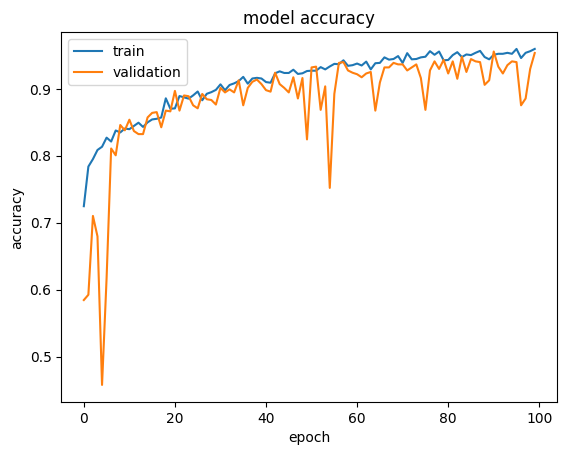

In [ ]:
from matplotlib import pyplot as plt

# Plot training accuracy & validation accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
# Add a legend to differentiate between training and validation accuracy
plt.legend(['Train', 'Validation'], loc='upper left')
# Display the plot
plt.show()


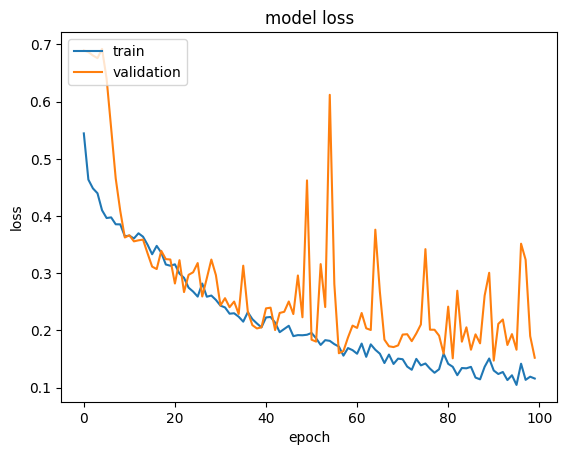

In [ ]:
# Plot training accuracy & validation accuracy over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

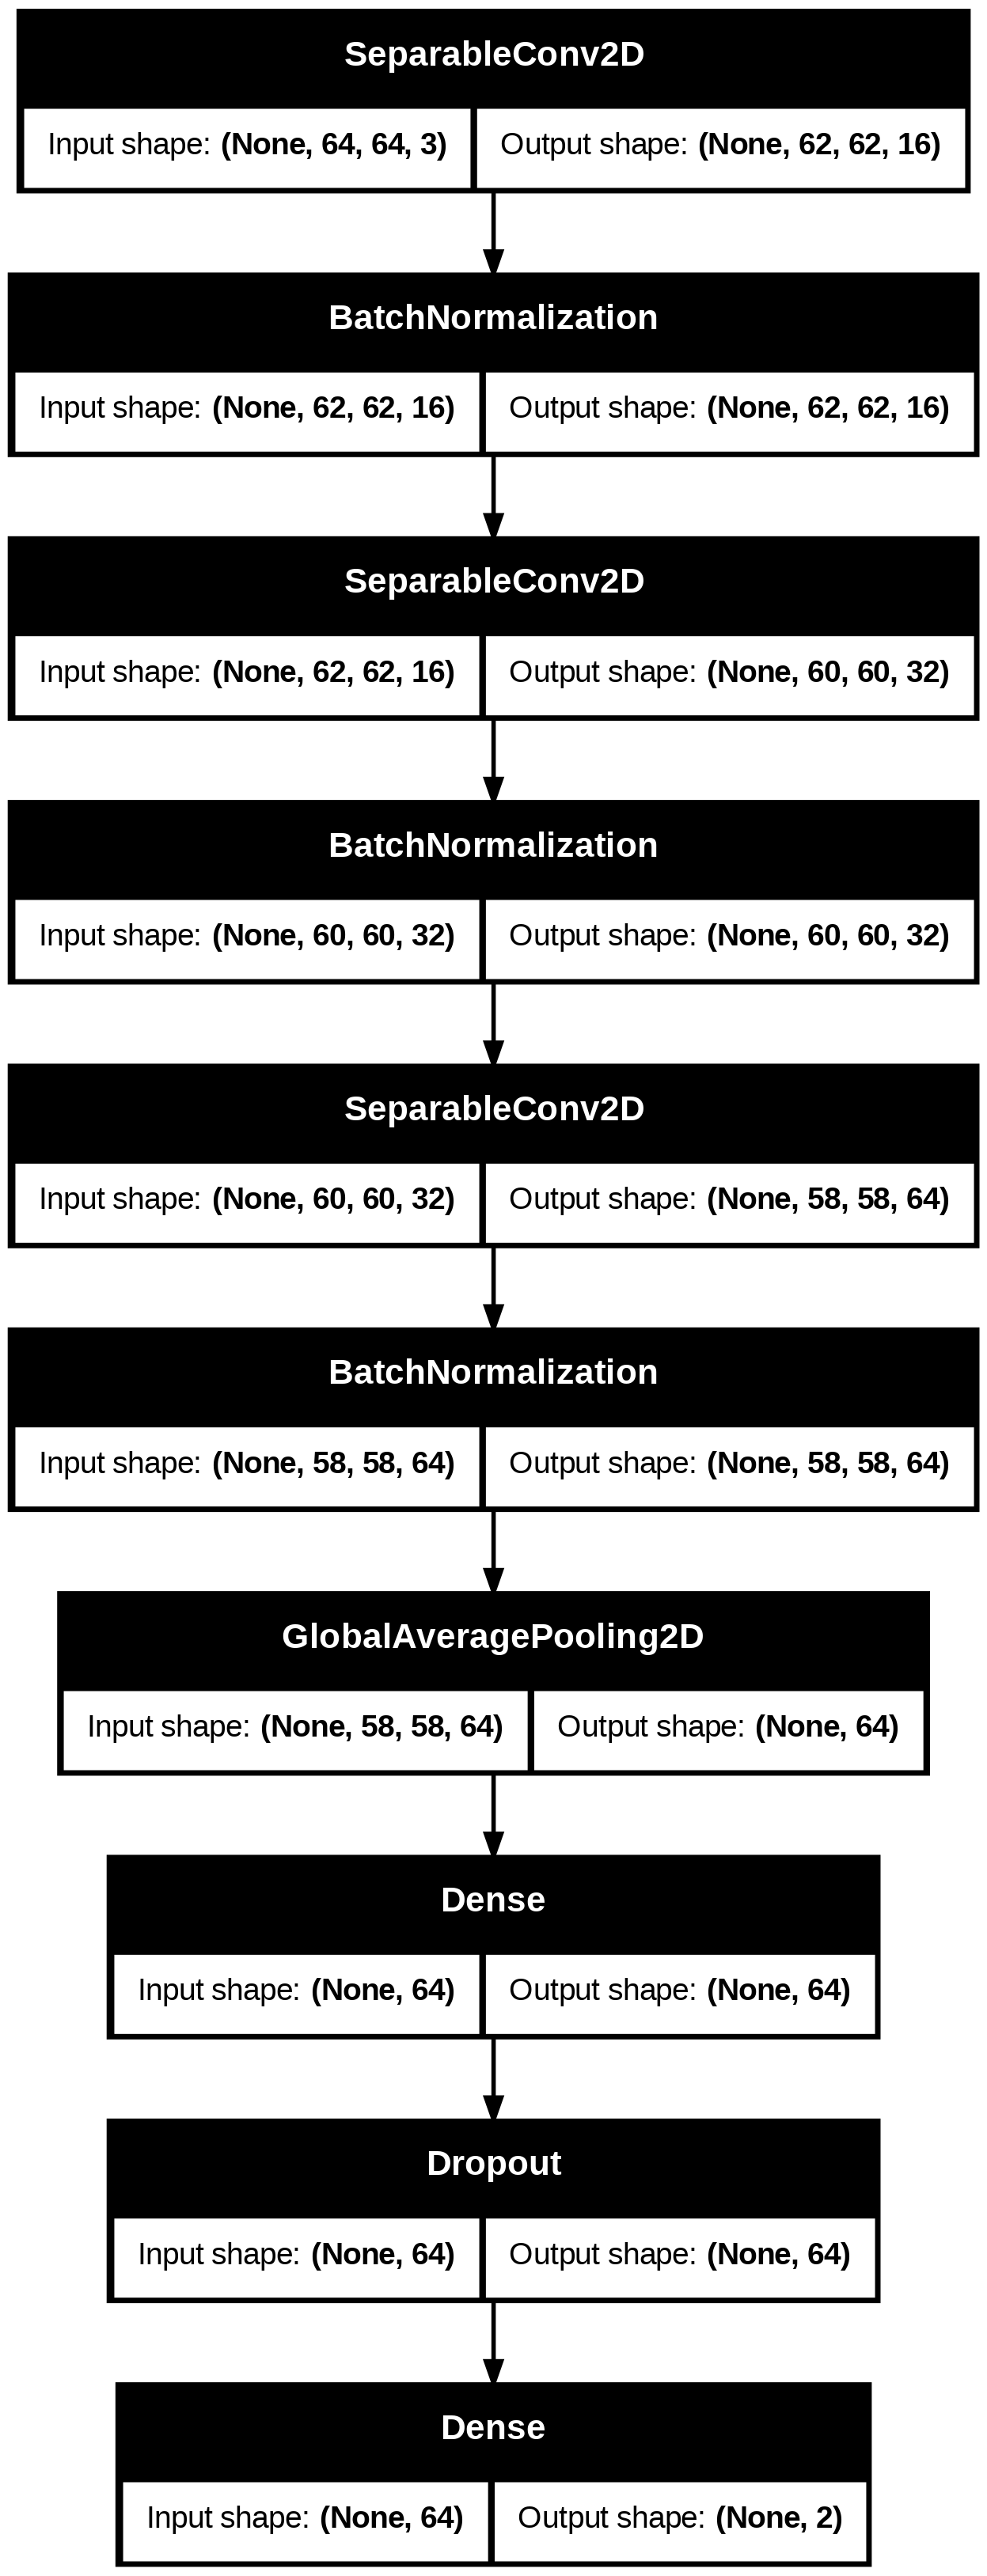

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

# Load the pre-trained model from the specified file path
model = tf.keras.models.load_model('/content/drive/MyDrive/TrainedModels/Fire-64x64-color-epoch91-val_acc0.96.h5')

# Generate and save a visualization of the model architecture
plot_model(model, to_file='model_small.png', show_layer_names=False, show_shapes=True)


#**Testing Model**

---



In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

In [ ]:
DATADIR = r'/content/drive/MyDrive/Test'

CATEGORIES = ['Fire', 'NoFire']

In [ ]:
IMG_SIZE = 64  # Resize all images to 64x64
def create_testing_data():
    testing_data = []
    for category in CATEGORIES:
# Load and preprocess images from each category folder (e.g., 'Fire' and 'NoFire')
        path = os.path.join(DATADIR,category)
        class_num = CATEGORIES.index(category)

        for img in tqdm(os.listdir(path)):
            try:
                img_array = cv2.imread(os.path.join(path,img))
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                testing_data.append([new_array, class_num])
            except Exception as e:
                pass

    return testing_data

In [ ]:
testing_data = create_testing_data()


100%|██████████| 388/388 [00:07<00:00, 52.23it/s]


In [ ]:
import random
test_image_num = 1001  # Number of test images to process

print(len(testing_data))  # Output the total number of training samples
random.shuffle(testing_data)  # Shuffle the training data to ensure randomness

test_labels = np.zeros((test_image_num, 1))  # Initialize an array to store labels

c = 0
for sample in testing_data:
    test_labels[c] = sample[1]  # Extract label from each sample
    c += 1

print(c)  # Confirm the number of labels extracted

actual_labels = test_labels.reshape(test_image_num,)  # Flatten to 1D array
print(actual_labels.shape)  # Output the shape of the labels array

actual_labels.astype(int)  # Convert labels to integer type


1001
1001
(1001,)


array([0, 1, 1, ..., 0, 0, 0])

In [ ]:
X = []
Y = []

for features, label in testing_data:
    X.append(features)  # Collect image data
    Y.append(label)     # Collect corresponding labels

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)  # Convert list to NumPy array and reshape
X = X / 255.0  # Normalize pixel values to [0, 1]
X.shape[1:]    # Retrieve shape of a single image (optional)

Y = np.array(Y)  # Convert labels list to NumPy array


In [ ]:


# Make predictions
predictions = model.predict(X)  # Returns probabilities for each class
predicted_labels = np.argmax(predictions, axis=1)  # Get class with highest probability

# Ensure correct shape & type
predicted_labels = predicted_labels.reshape(-1).astype(int)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step


Confusion matrix, without normalization
[[592  21]
 [ 57 331]]


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ separable_conv2d_3 (SeparableConv2D) │ (None, 62, 62, 16)          │              91 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 62, 62, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_4 (SeparableConv2D) │ (None, 60, 60, 32)          │             688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 60, 60, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_5 (SeparableConv2D) │ (None, 58, 58, 64)          │           2,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 58, 58, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,919 (30.94 KB)

 Trainable params: 7,693 (30.05 KB)

 Non-trainable params: 224 (896.00 B)

 Optimizer params: 2 (12.00 B)

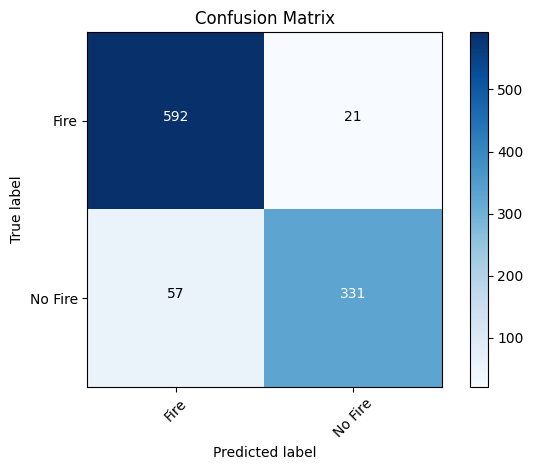

In [ ]:
from matplotlib import pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(actual_labels, predicted_labels)
#test_batches.class_indices
cm_plot_labels=['Fire','No Fire']
plot_confusion_matrix(cm, cm_plot_labels,title='Confusion Matrix')

model.summary()

In [ ]:
tp=cm[0][0]
fn=cm[0][1]
fp=cm[1][0]
tn=cm[1][1]
print("true positive"+' '+str(tp))
print("false negitive"+' '+str(fn))
print("false positive"+' '+str(fp))
print("true negitive"+' '+str(tn))

true positive 592
false negitive 21
false positive 57
true negitive 331


In [ ]:
Recall=tp/(tp+fn)
Precision=tp/(tp+fp)
f_measure= 2*((Precision*Recall)/(Precision+Recall))

print(Precision, Recall, f_measure)



0.9121725731895224 0.965742251223491 0.9381933438985736


In [ ]:
from sklearn.metrics import classification_report

# Generate the classification report
class_names = ['Fire', 'NoFire']
report = classification_report(actual_labels, predicted_labels, target_names=class_names)

print("\nClassification Report:")
print(report)



Classification Report:
              precision    recall  f1-score   support

        Fire       0.91      0.97      0.94       613
      NoFire       0.94      0.85      0.89       388

    accuracy                           0.92      1001
   macro avg       0.93      0.91      0.92      1001
weighted avg       0.92      0.92      0.92      1001



In [ ]:
model.evaluate(X, Y)

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.9158 - loss: 0.2124


[0.20043104887008667, 0.9220778942108154]

#**Task 3**

---



In [ ]:
# -------------------------- Final Evaluation: Comparison Table --------------------------

# Import pandas for creating a neat tabular display
import pandas as pd

# Create a dictionary of our comparison metrics
data = {
    "Model": ["My FireNet Model", "FireNet-Micro", "FireNet-v2", "FireNet"],
    "Parameters": [7693, 171234, 318460, 646818],
    "Accuracy (%)": [92.00, 96.78, 94.95, 93.91],
    "Precision (%)": [91.21, 97.80, 99.28, 97.00],
    "Recall (%)": [96.57, 97.47, 93.25, 94.00]
}

# Convert the dictionary to a DataFrame (table)
df = pd.DataFrame(data)

# Print the resulting table
print("\nComparison of Model Performance:")
print(df)



Comparison of Model Performance:
              Model  Parameters  Accuracy (%)  Precision (%)  Recall (%)
0  My FireNet Model        7693         92.00          91.21       96.57
1     FireNet-Micro      171234         96.78          97.80       97.47
2        FireNet-v2      318460         94.95          99.28       93.25
3           FireNet      646818         93.91          97.00       94.00


#**Task 4**

---



Total new images loaded: 20

Displaying 5 random images from the New Images dataset:


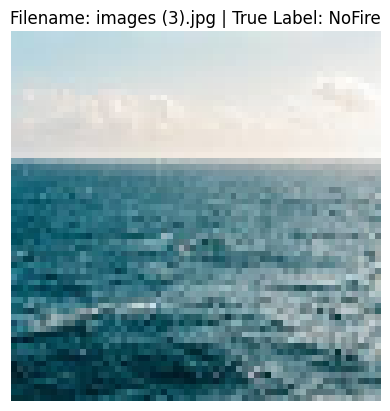

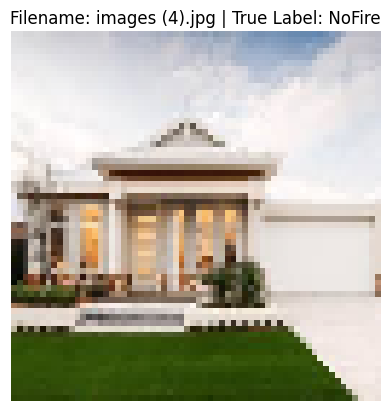

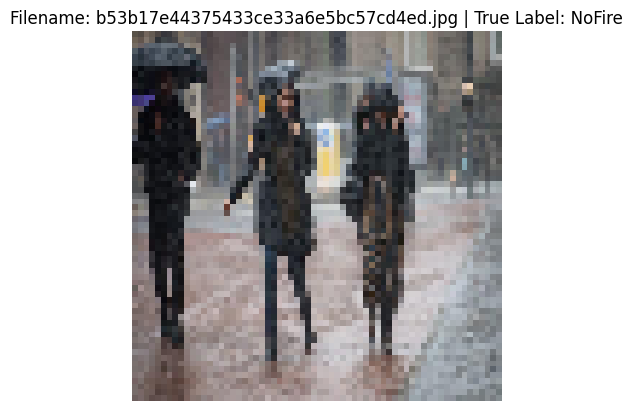

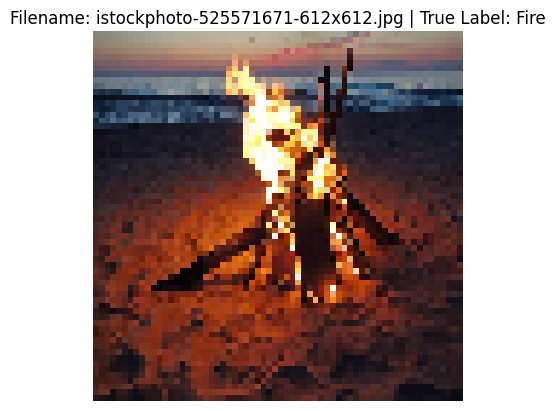

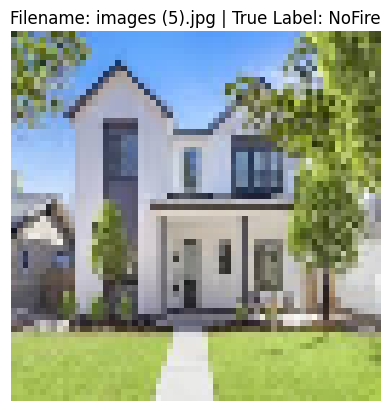

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step

Inference Results on New Images:
Image: 62.jpg --> Predicted: Fire
Image: 360_F_543057557_iIFdOITjSpKnPTguAzbz0FCUwN8vIlIb.jpg --> Predicted: Fire
Image: depositphotos_471512808-stock-photo-una-calida-fogata-llameante.jpg --> Predicted: Fire
Image: images.jpg --> Predicted: Fire
Image: images (1).jpg --> Predicted: Fire
Image: depositphotos_62857879-stock-photo-bonfire.jpg --> Predicted: Fire
Image: istockphoto-525571671-612x612.jpg --> Predicted: Fire
Image: istockphoto-186805160-612x612.jpg --> Predicted: Fire
Image: istockphoto-172376898-612x612.jpg --> Predicted: Fire
Image: house-fire-1.jpg --> Predicted: Fire
Image: images.jpg --> Predicted: NoFire
Image: images (1).jpg --> Predicted: NoFire
Image: images (2).jpg --> Predicted: NoFire
Image: b53b17e44375433ce33a6e5bc57cd4ed.jpg --> Predicted: Fire
Image: images (3).jpg --> Predicted: NoFire
Image: iStock-1405520633-1024x682.jpg --> Predicted: NoFire
Image: images (4).jpg --> Predicted: NoFi

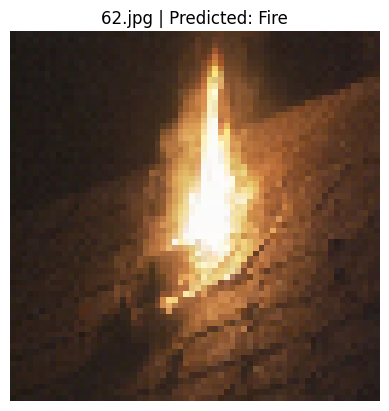

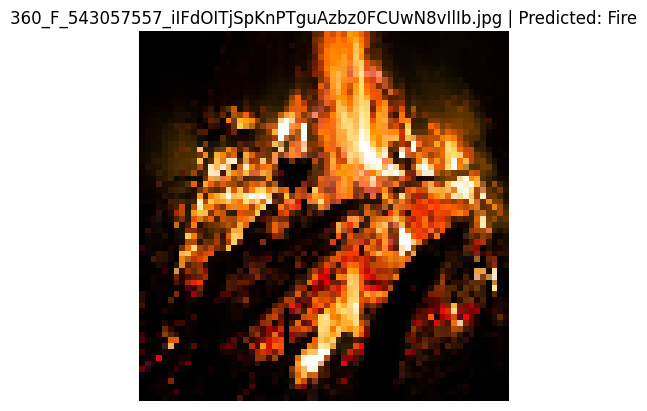

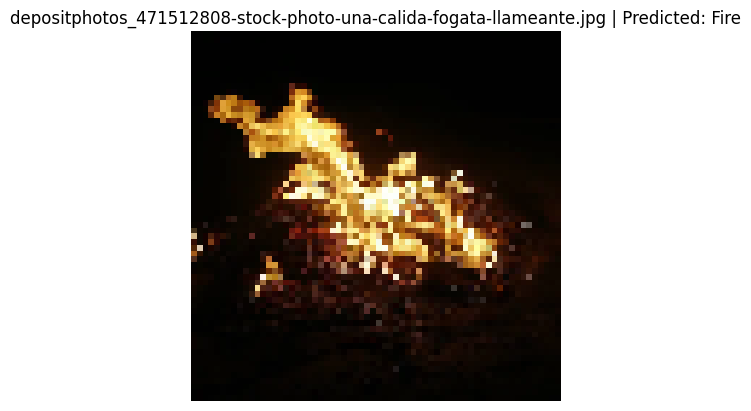

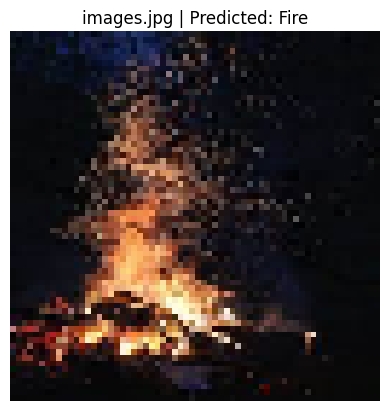

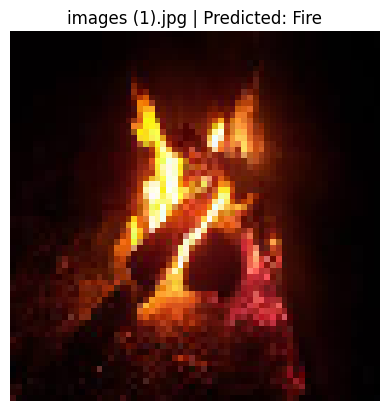

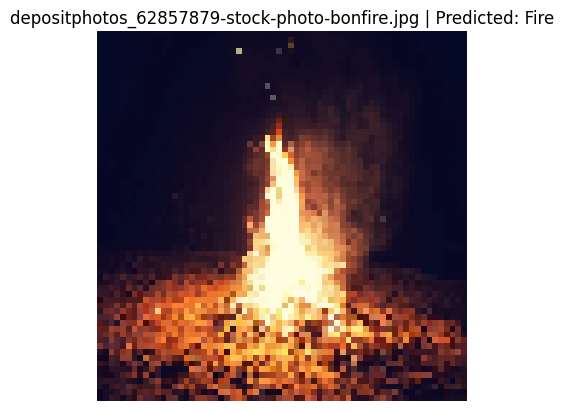

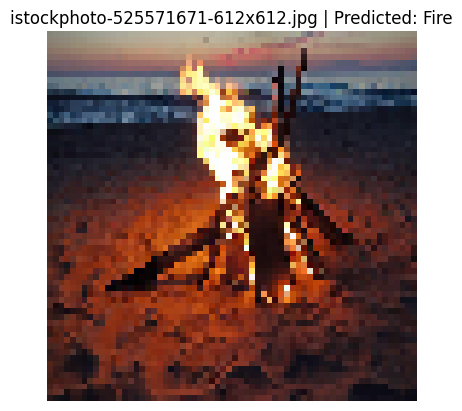

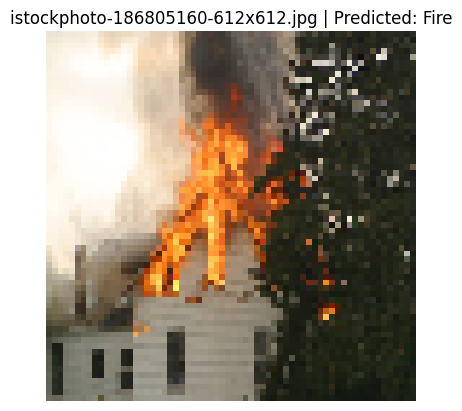

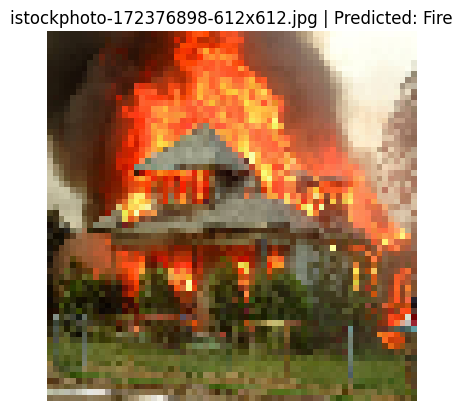

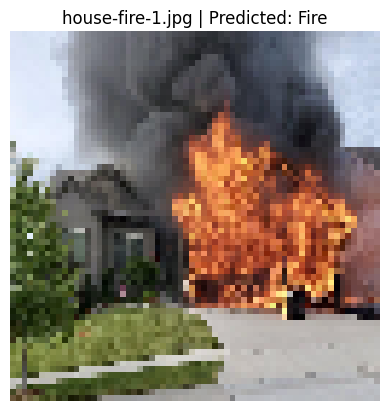

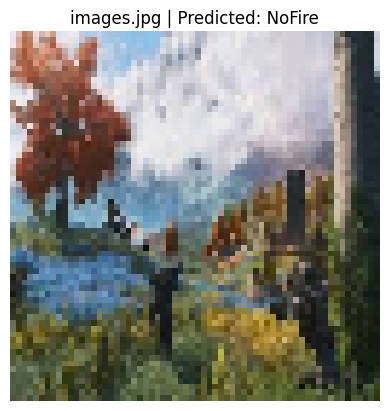

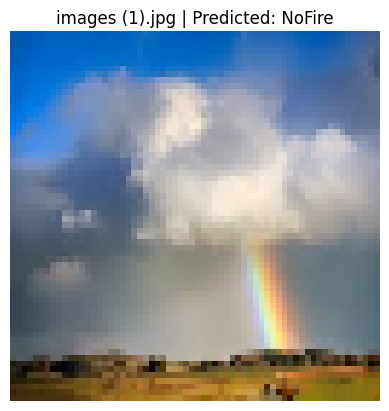

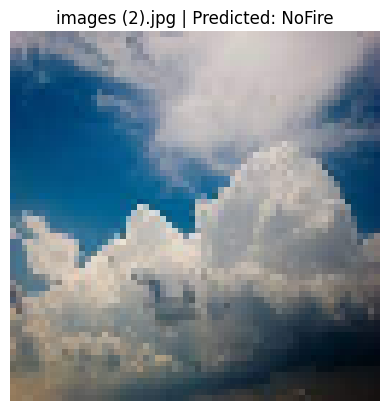

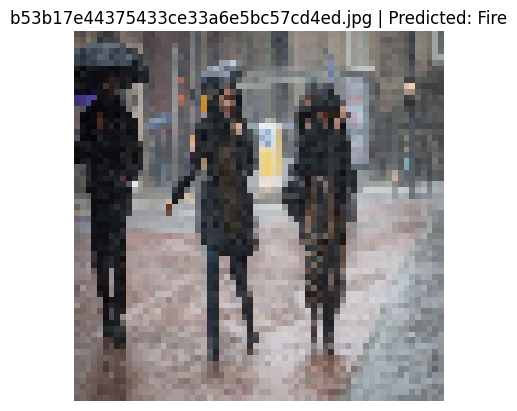

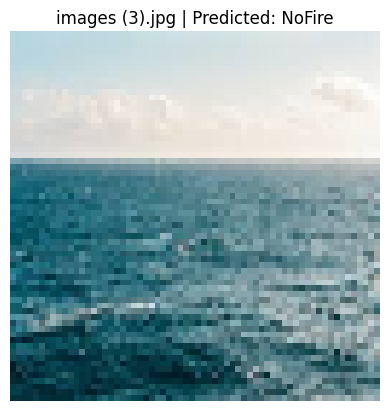

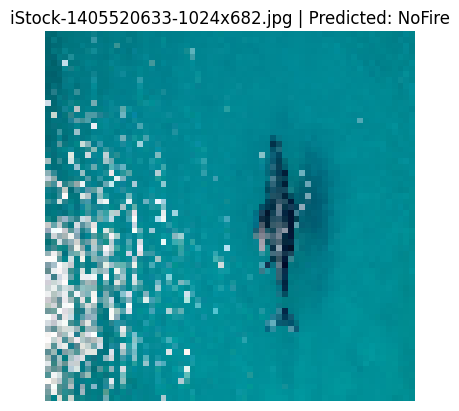

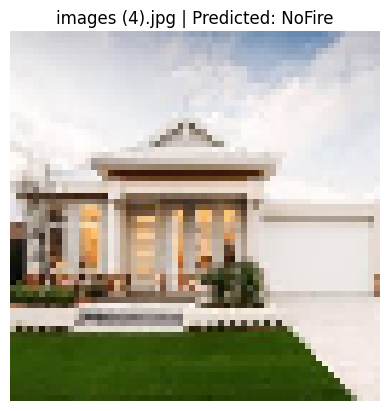

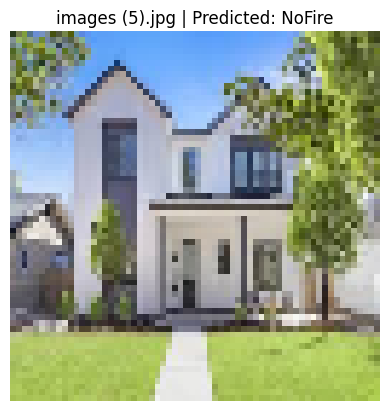

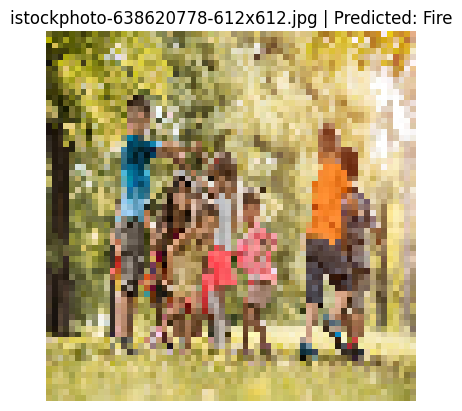

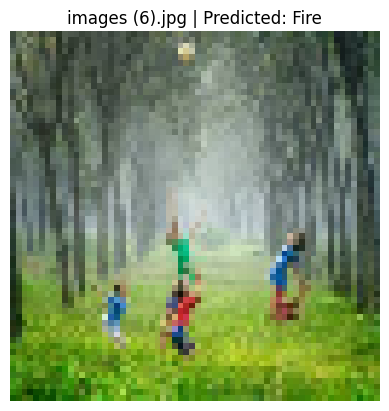


Out of 20 new images, 17 predictions were correct.

Confusion Matrix for New Images:
[[10  0]
 [ 3  7]]
Confusion matrix, without normalization
[[10  0]
 [ 3  7]]


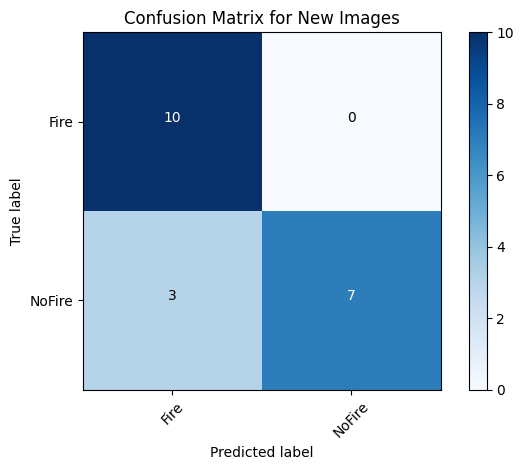

In [ ]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import itertools
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

NEW_IMG_DIR = '/content/drive/MyDrive/NewImages'
# Define the classes for new images.
NEW_CATEGORIES = ['Fire', 'NoFire']

def create_new_data(directory):

    data = []
    for category in NEW_CATEGORIES:
        path = os.path.join(directory, category)
        # Get class number (0 for 'Fire', 1 for 'NoFire')
        class_num = NEW_CATEGORIES.index(category)
        # Loop over each file in the category sub-folder
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                # Read the image from disk using OpenCV (BGR format)
                img_array = cv2.imread(img_path)
                # Resize the image to IMG_SIZE x IMG_SIZE; IMG_SIZE is assumed to be defined (64)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                # Append image, its label, and the filename
                data.append([new_array, class_num, img])
            except Exception as e:
                print(f"Error processing {img}: {e}")
    return data

# Load the new dataset
new_data = create_new_data(NEW_IMG_DIR)
print("Total new images loaded:", len(new_data))

# =============================================================================
# Separate features, labels, and filenames
# =============================================================================
X_new = [item[0] for item in new_data]
Y_new = [item[1] for item in new_data]
filenames_new = [item[2] for item in new_data]

# Convert the images to a NumPy array and normalize pixel values to [0, 1]
X_new = np.array(X_new, dtype=np.float32) / 255.0
Y_new = np.array(Y_new, dtype=np.int32)

# =============================================================================
# Display 5 Random Images from the New Dataset
# =============================================================================
def display_random_new_images(X_data, Y_data, filenames, num_images=5):

    indices = random.sample(range(len(X_data)), num_images)
    for idx in indices:
        img = X_data[idx]
        true_label = NEW_CATEGORIES[Y_data[idx]]
        fname = filenames[idx]
        # Convert image from BGR (as read by OpenCV) to RGB for displaying correctly.
        img_rgb = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_BGR2RGB)
        plt.figure()
        plt.imshow(img_rgb)
        plt.title(f"Filename: {fname} | True Label: {true_label}")
        plt.axis('off')
        plt.show()

# Display 5 random images from the new dataset for visual verification.
print("\nDisplaying 5 random images from the New Images dataset:")
display_random_new_images(X_new, Y_new, filenames_new, num_images=5)

# =============================================================================
# Model Inference on New Images
# =============================================================================

best_model_path = '/content/drive/MyDrive/TrainedModels/Fire-64x64-color-epoch91-val_acc0.96.h5'
model = tf.keras.models.load_model(best_model_path)

# Make predictions on the new images.
predictions_new = model.predict(X_new)
# Since the final layer uses softmax,we use argmax to get the predicted class labels.
predicted_labels_new = np.argmax(predictions_new, axis=1)
predicted_labels_new = predicted_labels_new.reshape(-1).astype(int)

# Print inference result for each new image.
print("\nInference Results on New Images:")
for i, fname in enumerate(filenames_new):
    pred_class = NEW_CATEGORIES[predicted_labels_new[i]]
    print(f"Image: {fname} --> Predicted: {pred_class}")

# Display all new images with their predicted labels.
for i, fname in enumerate(filenames_new):
    img = X_new[i]
    # Convert BGR to RGB for correct color display.
    img_rgb = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(img_rgb)
    plt.title(f"{fname} | Predicted: {NEW_CATEGORIES[predicted_labels_new[i]]}")
    plt.axis('off')
    plt.show()

# =============================================================================
# Evaluate Inference Results on New Images
# =============================================================================
# Calculate the total number of correct predictions.
correct_predictions = np.sum(predicted_labels_new == Y_new)
total_new = len(Y_new)
print(f"\nOut of {total_new} new images, {correct_predictions} predictions were correct.")

# Compute the confusion matrix for the new images.
cm_new = confusion_matrix(Y_new, predicted_labels_new)
print("\nConfusion Matrix for New Images:")
print(cm_new)

# Function to plot the confusion matrix.
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Plot the confusion matrix for the new images.
plot_confusion_matrix(cm_new, classes=NEW_CATEGORIES, title="Confusion Matrix for New Images")
plt.show()




In [ ]:
!jupyter nbconvert Ghous_group_Project.ipynb --to html

[NbConvertApp] Converting notebook Ghous_group_Project.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 40 image(s).
[NbConvertApp] Writing 1998214 bytes to Ghous_group_Project.html
